In [1]:
import numpy as np
from scipy import fft
import NAFFlib as naf
import statistics as st
from matplotlib.widgets import Slider
import matplotlib.pyplot as plt
import re
import time
import random

np.random.seed(0)

In [2]:
Name_xbpms = []
Name_ybpms = []
Pos_xbpms = np.zeros([1024, 168])
Pos_ybpms = np.zeros([1024, 167])
S_xbpms = np.zeros([1024, 168])
S_ybpms = np.zeros([1024, 167])
with open('data_Wed_Jun_28_20-13-14_2023') as output:
    Lines = output.readlines()
    index_ix = index_jx = 0
    index_iy = index_jy = 0
    init_i = 414
    for i, line in enumerate(Lines[1:]):
        Line = []
        #xBPM Names
        if i >= 67 and i < 95:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_xbpms.append(Line[:-1])
        
        #yBPM Names
        if i >= 241 and i < 269:
            for word in re.split("\s+", line):
                Line.append(word)
            Name_ybpms.append(Line[:-1])
           
        #s and positions for xBPM
        if i > init_i:
            row = re.split("\s+", line)
            S_xbpms[index_ix][index_jx] = float(row[1])
            Pos_xbpms[index_ix][index_jx] = float(row[2])
            index_jx = (i - init_i)%168
            
            if (i - init_i)%168 == 0 and (i - init_i) != 0:
                index_ix += 1
        
        #s and positions for yBPM
        if i > init_i and i < 171423:
            row = re.split("\s+", line)
            S_ybpms[index_iy][index_jy] = float(row[6])
            Pos_ybpms[index_iy][index_jy] = float(row[7])
            index_jy = (i - init_i)%167
            
            if (i - init_i)%167 == 0 and (i - init_i) != 0:
                index_iy += 1
        
Name_xbpms = [item for row in Name_xbpms for item in row]
Name_ybpms = [item for row in Name_ybpms for item in row]

In [3]:
# Positions
init_turn = 0 # Starting turn
BPMx = Pos_xbpms.T[:, init_turn:] #np.loadtxt('BPMx.csv', delimiter=',')[:, init_turn:]
BPMy = Pos_ybpms.T[:, init_turn:] #np.loadtxt('BPMy.csv', delimiter=',')[:, init_turn:]

N_BPMx, N_turns = np.shape(BPMx) #(168, 1014)
N_BPMy, _ = np.shape(BPMy) #(167, 1014)

Standard deviation of Third Horizontal BPM = 0.08086005371776343


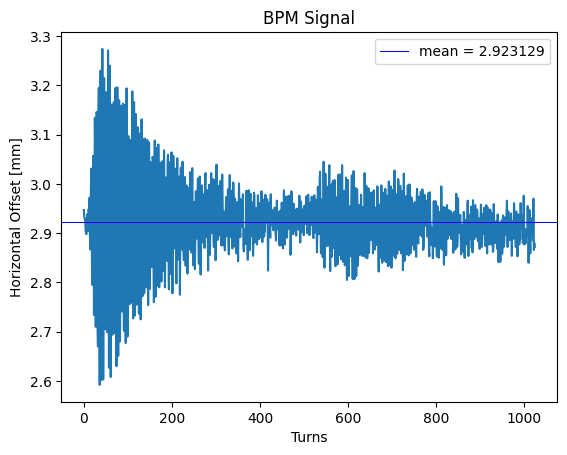

In [4]:
BPMx0 = BPMx[0]

BPMx0_mean = np.mean(BPMx0)
BPMx0_std = np.std(BPMx0)
print("Standard deviation of Third Horizontal BPM =", BPMx0_std)

x = np.linspace(init_turn, N_turns, N_turns)
plt.plot(x, BPMx0)
plt.axhline(y = BPMx0_mean, color = 'b', linestyle = '-', linewidth = .75, label = r"mean = %f"%BPMx0_mean)
plt.xlabel("Turns")
plt.ylabel("Horizontal Offset [mm]")
plt.title("BPM Signal")
plt.legend()
plt.show()

Scipy Tune: 0.23483365949119372
NAFFlib Tune: 0.23522844023299927


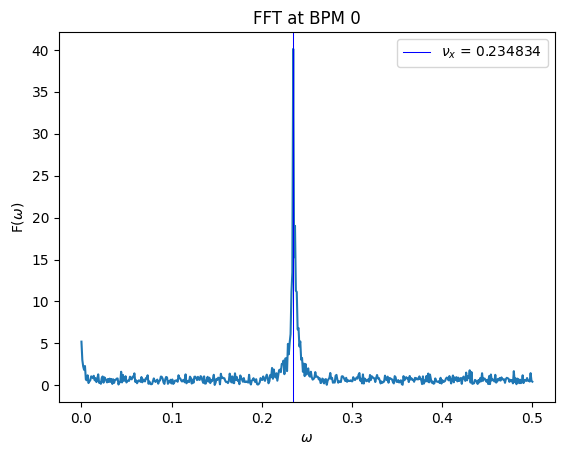

In [5]:
# Scipy to figure out tune
Omega = np.linspace(0, N_turns//2, N_turns//2)/N_turns

BPMX0 = np.abs(fft.rfft(BPMx0)[1:])
BPMx0_Tune_scipy = Omega[np.argmax(BPMX0)]
BPMx0_Tune = naf.get_tune(BPMx0)
print("Scipy Tune:", BPMx0_Tune_scipy)
print("NAFFlib Tune:", BPMx0_Tune)

plt.plot(Omega, BPMX0)
plt.axvline(x = BPMx0_Tune_scipy, color = 'b', linestyle = '-', linewidth = .75, label = r"$\nu_x$ = %f"%BPMx0_Tune_scipy)
plt.title("FFT at BPM 0")
plt.xlabel(r"$\omega$")
plt.ylabel(r"F($\omega$)")
plt.legend()
plt.show()

In [6]:
# How x_model is calculated
# What is phi_i?? Is that gotten from the computer
# How is P_x incorporated into calculating x_model?
# def model(x_i, x_c, P_x, nu_x, eps_SR, eps_NL): 
#     res = np.zeros(N_turns)
#     phi_i = np.arctan(P_x/(x_0 - x_c))
#     for j in range(N_turns):
#         A_j = np.exp(-eps_SR - eps_NL**2*j**2)
#         res[j] = x_c + A_j*x_0*np.cos(2*np.pi*nu_x*j + phi_i)
#     return res

def model(x0, xp0, x_c, beta, alpha, nu_x, eps_SR, eps_NL, eps_E, nu_s, phi_s):
    res = np.zeros(N_turns)
    alpha_j = 2*eps_E*np.sin(np.pi*nu_s*res + phi_s)/nu_s
    alpha_j0 = 2*eps_E*np.sin(phi_s)/nu_s
    A_j = np.exp(-(alpha_j**2-alpha_j0**2)/2 - eps_NL**2*res**2 - eps_SR*res)
    m11 = np.cos(2*np.pi*nu_x*res) + alpha*np.sin(2*np.pi*nu_x*res)
    m12 = beta*np.sin(2*np.pi*nu_x*res)
    return A_j*(m11*(x0 - x_c) + m12*xp0) + x_c

# P(X_data|theta)
def Likelihood(X_data, Theta, sigma):
    x0, xp0, x_c, beta, alpha, nu_x, eps_SR, eps_NL, eps_E, nu_s, phi_s = Theta
    X_model = model(x0, xp0, x_c, beta, alpha, nu_x, eps_SR, eps_NL, eps_E, nu_s, phi_s)
    Diff = X_data - X_model
    #print(Diff)
    return np.exp(-np.sum((Diff)**2)/(2*sigma**2))
    

In [7]:
# Metropolis Hastings: a Markov Chain Monte Carlo method
# Should I get uncertainties from RHIC or paper?
def MCMCMH(X_data, Theta, N_sim, Sigma_theta, sinitials, sstep):
    Theta_Hist = [Theta]
    Theta_prev = np.copy(Theta)
    s_prev = sinitials[0]
    s_next = 0
    #How to find initial prior for initial values
    pi_prev = Likelihood(X_data, Theta_prev, s_prev)
    
    for i in range(N_sim):
        Theta_next = np.copy(Theta_prev)
        Theta_next += np.random.normal(size = len(Theta))*Sigma_theta
        s_next += np.random.normal(1)*sstep[0]
        pi_next = Likelihood(X_data, Theta_next, s_next)*pi_prev
        
#         if Theta_next[3] < 0: #Non negative beta
#             continue
#         if Theta_next[6] < 0: # SR_eps  > 0
#             continue
#         if Theta_next[7] < 0: # nl_eps  > 0
#             continue
#         if Theta_next[8] < 0: # xi*sige > 0
#             continue
#         if Theta_next[9] <= 0: # nuz > 0
#             continue
#         if Theta_next[10] > np.pi:
#             Theta_next[10] -= 2*np.pi
#         if Theta_next[10] < -np.pi: 
#             Theta_next[10] += 2*np.pi
        
        u = np.random.rand(0, 1)
        #print(pi_next, pi_prev)
        if u < np.minimum(pi_next/pi_prev, 1):
            Theta_prev = np.copy(Theta_next)
            s_prev = s_next
            pi_prev = pi_next
        Theta_Hist.append(Theta_next)
    return Theta_Hist

In [10]:
# x_i, x_c, P_x, nu_x, eps_SR, eps_NL
Theta_0 = np.array([BPMx0[0], 0, BPMx0_mean, 1, 0, BPMx0_Tune_scipy, 0, 0, 0, 8e-3, 0.1])
print("Theta:", Theta_0)
Sigma_theta = np.array([1e-3, 1e-3, 1e-3, 0, 0, 5e-7, 1e-6, 1e-6, 0, 1e-4, 3e-3])
Theta_names = [r"$x_0$", r"$x^'_0$", r"$x_c$", r"$\beta_x$", r"$\alpha_x$", r"$\nu_x$", r"$\epsilon_{SR}$", 
               r"$\epsilon_{NL}$", r"$\epsilon_E$", r"$\nu_s$", r"$\phi_s$"]
sinitials=[1e-2,0e-2]
sstep=[2e-4,0e-3]

N_sim = 50000
begin = time.time()
Theta_Hist = MCMCMH(BPMx0, Theta_0, N_sim, Sigma_theta, sinitials, sstep)
end = time.time()
print("Time elapsed:", end - begin)
print("Final values:", Theta_Hist[-1])

Theta: [2.94700003 0.         2.92312891 1.         0.         0.23483366
 0.         0.         0.         0.008      0.1       ]


/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2478/550687641.py:34: RuntimeWarning: invalid value encountered in double_scalars
  if u < np.minimum(pi_next/pi_prev, 1):
/var/folders/r3/ccbllzdn2pb3wzn_b988y1n80000gp/T/ipykernel_2478/550687641.py:34: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if u < np.minimum(pi_next/pi_prev, 1):


Time elapsed: 7.402443170547485
Final values: [ 2.94753069e+00 -1.10916430e-03  2.92389503e+00  1.00000000e+00
  0.00000000e+00  2.34833928e-01  3.49697346e-07 -2.99589218e-07
  0.00000000e+00  7.77402044e-03  1.01776864e-01]


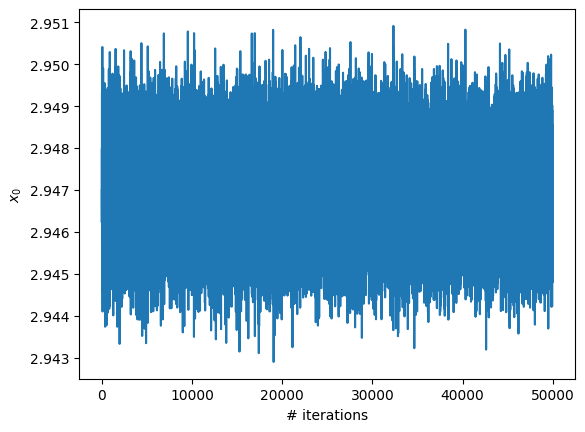

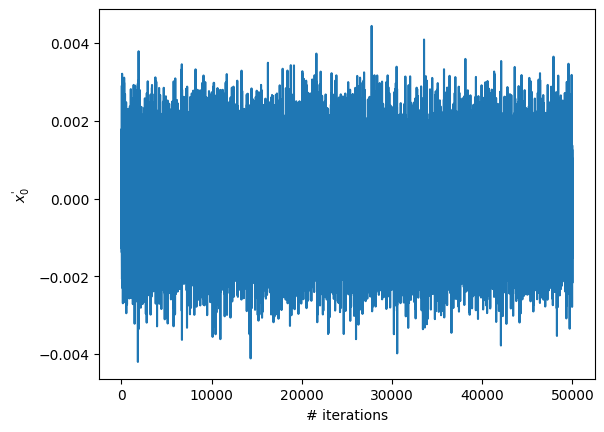

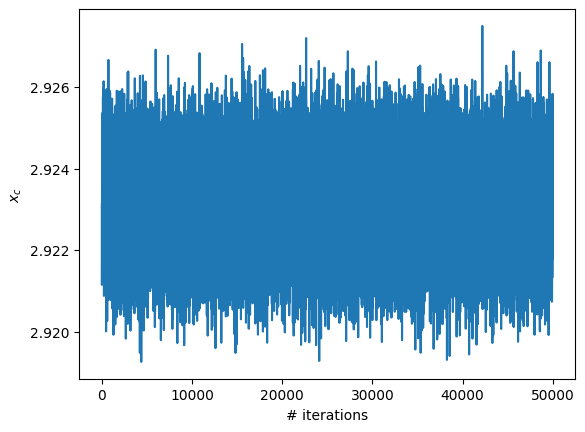

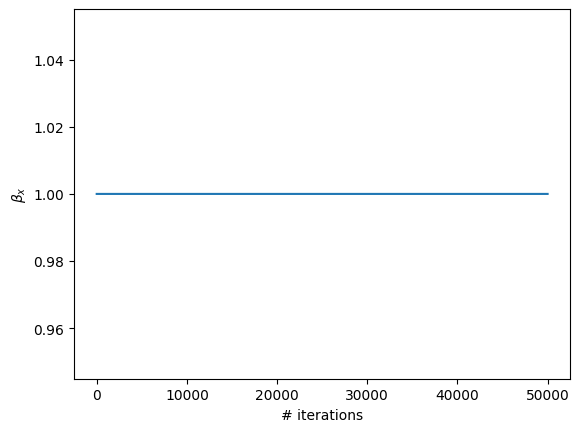

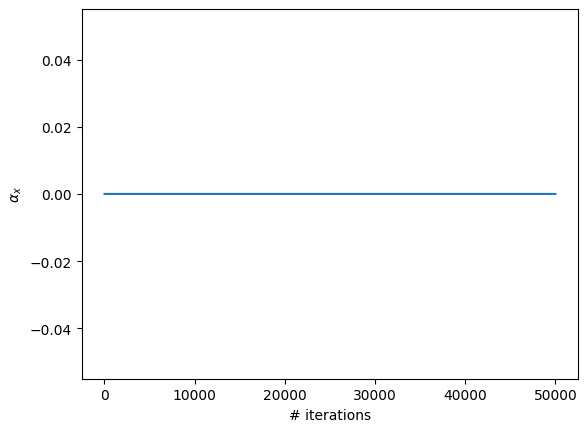

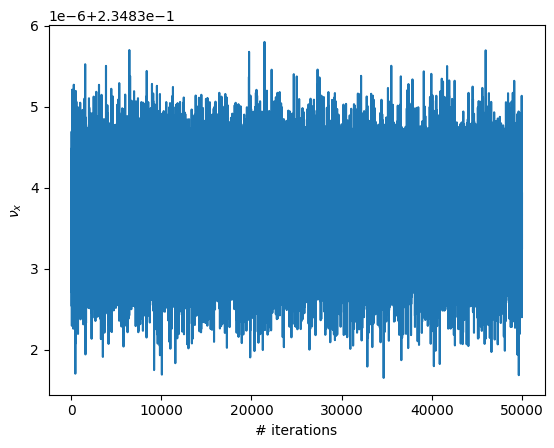

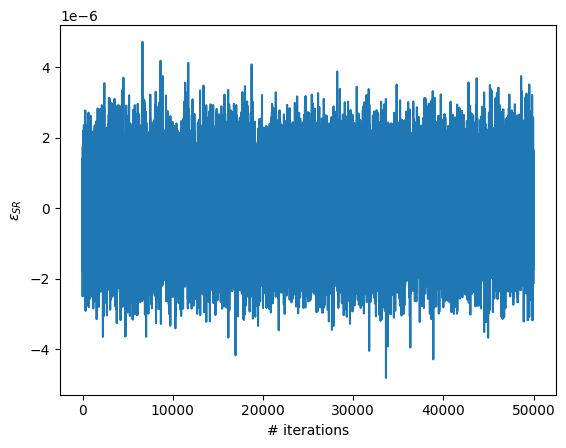

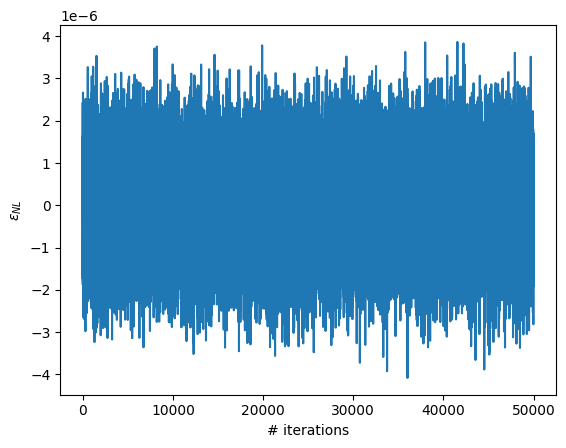

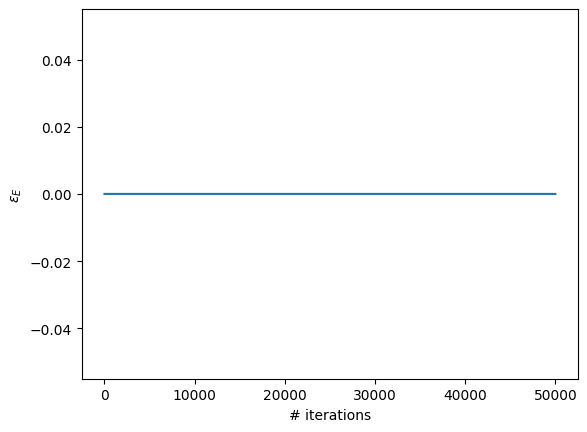

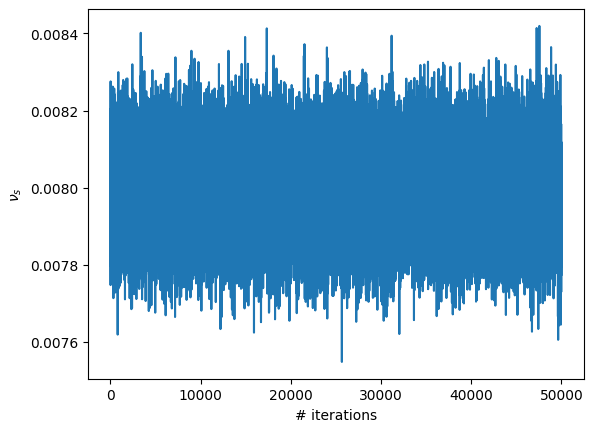

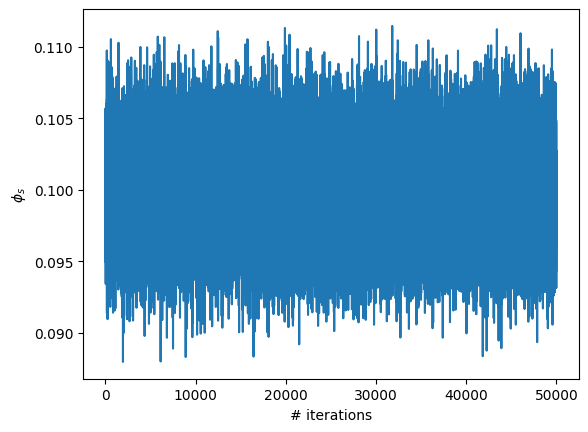

In [11]:
x_sim = np.linspace(0, N_sim, N_sim + 1)
Theta_Hist = np.array(Theta_Hist).T
for i, theta in enumerate(Theta_Hist):
    plt.plot(theta)
    plt.xlabel("# iterations")
    plt.ylabel(Theta_names[i])
    plt.show()

In [ ]:
np.random.seed(1)

In [ ]:
x_sim = np.linspace(0, N_sim, N_sim + 1)
Theta_Hist = np.array(Theta_Hist).T
for i, theta in enumerate(Theta_Hist):
    plt.plot(x_sim, theta)
    plt.xlabel("# iterations")
    plt.ylabel(Theta_names[i])
    plt.show()